In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

In [2]:
from src.inference.config import SBI_CONFIG

print("=== Configuración SBI ===")
for key, value in SBI_CONFIG.items():
    print(f"{key}: {value}")

=== Configuración SBI ===
num_simulations: 5000
training_batch_size: 50
training_epochs: 100
validation_fraction: 0.1
hidden_features: 50
num_transforms: 5
device: cpu
model_save_path: results\inference\trained_model_3.pkl


In [3]:
from src.inference.config import PARAM_RANGES

print("\n=== Rangos de Parámetros para el Prior ===")
for param, (low, high) in PARAM_RANGES.items():
    print(f"{param}: [{low}, {high}]")


=== Rangos de Parámetros para el Prior ===
Omega_m: [0.1, 0.7]
Omega_b: [0.04, 0.06]
h: [0.6, 0.8]
sigma_8: [0.6, 1.1]
ns: [0.9, 1.0]
tau: [0.04, 0.08]


In [4]:
from src.inference.prior import get_prior

prior = get_prior()
print("\n=== Distribución Prior ===")
print(prior)

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Distribución Prior ===
BoxUniform(Uniform(low: torch.Size([6]), high: torch.Size([6])), 1)


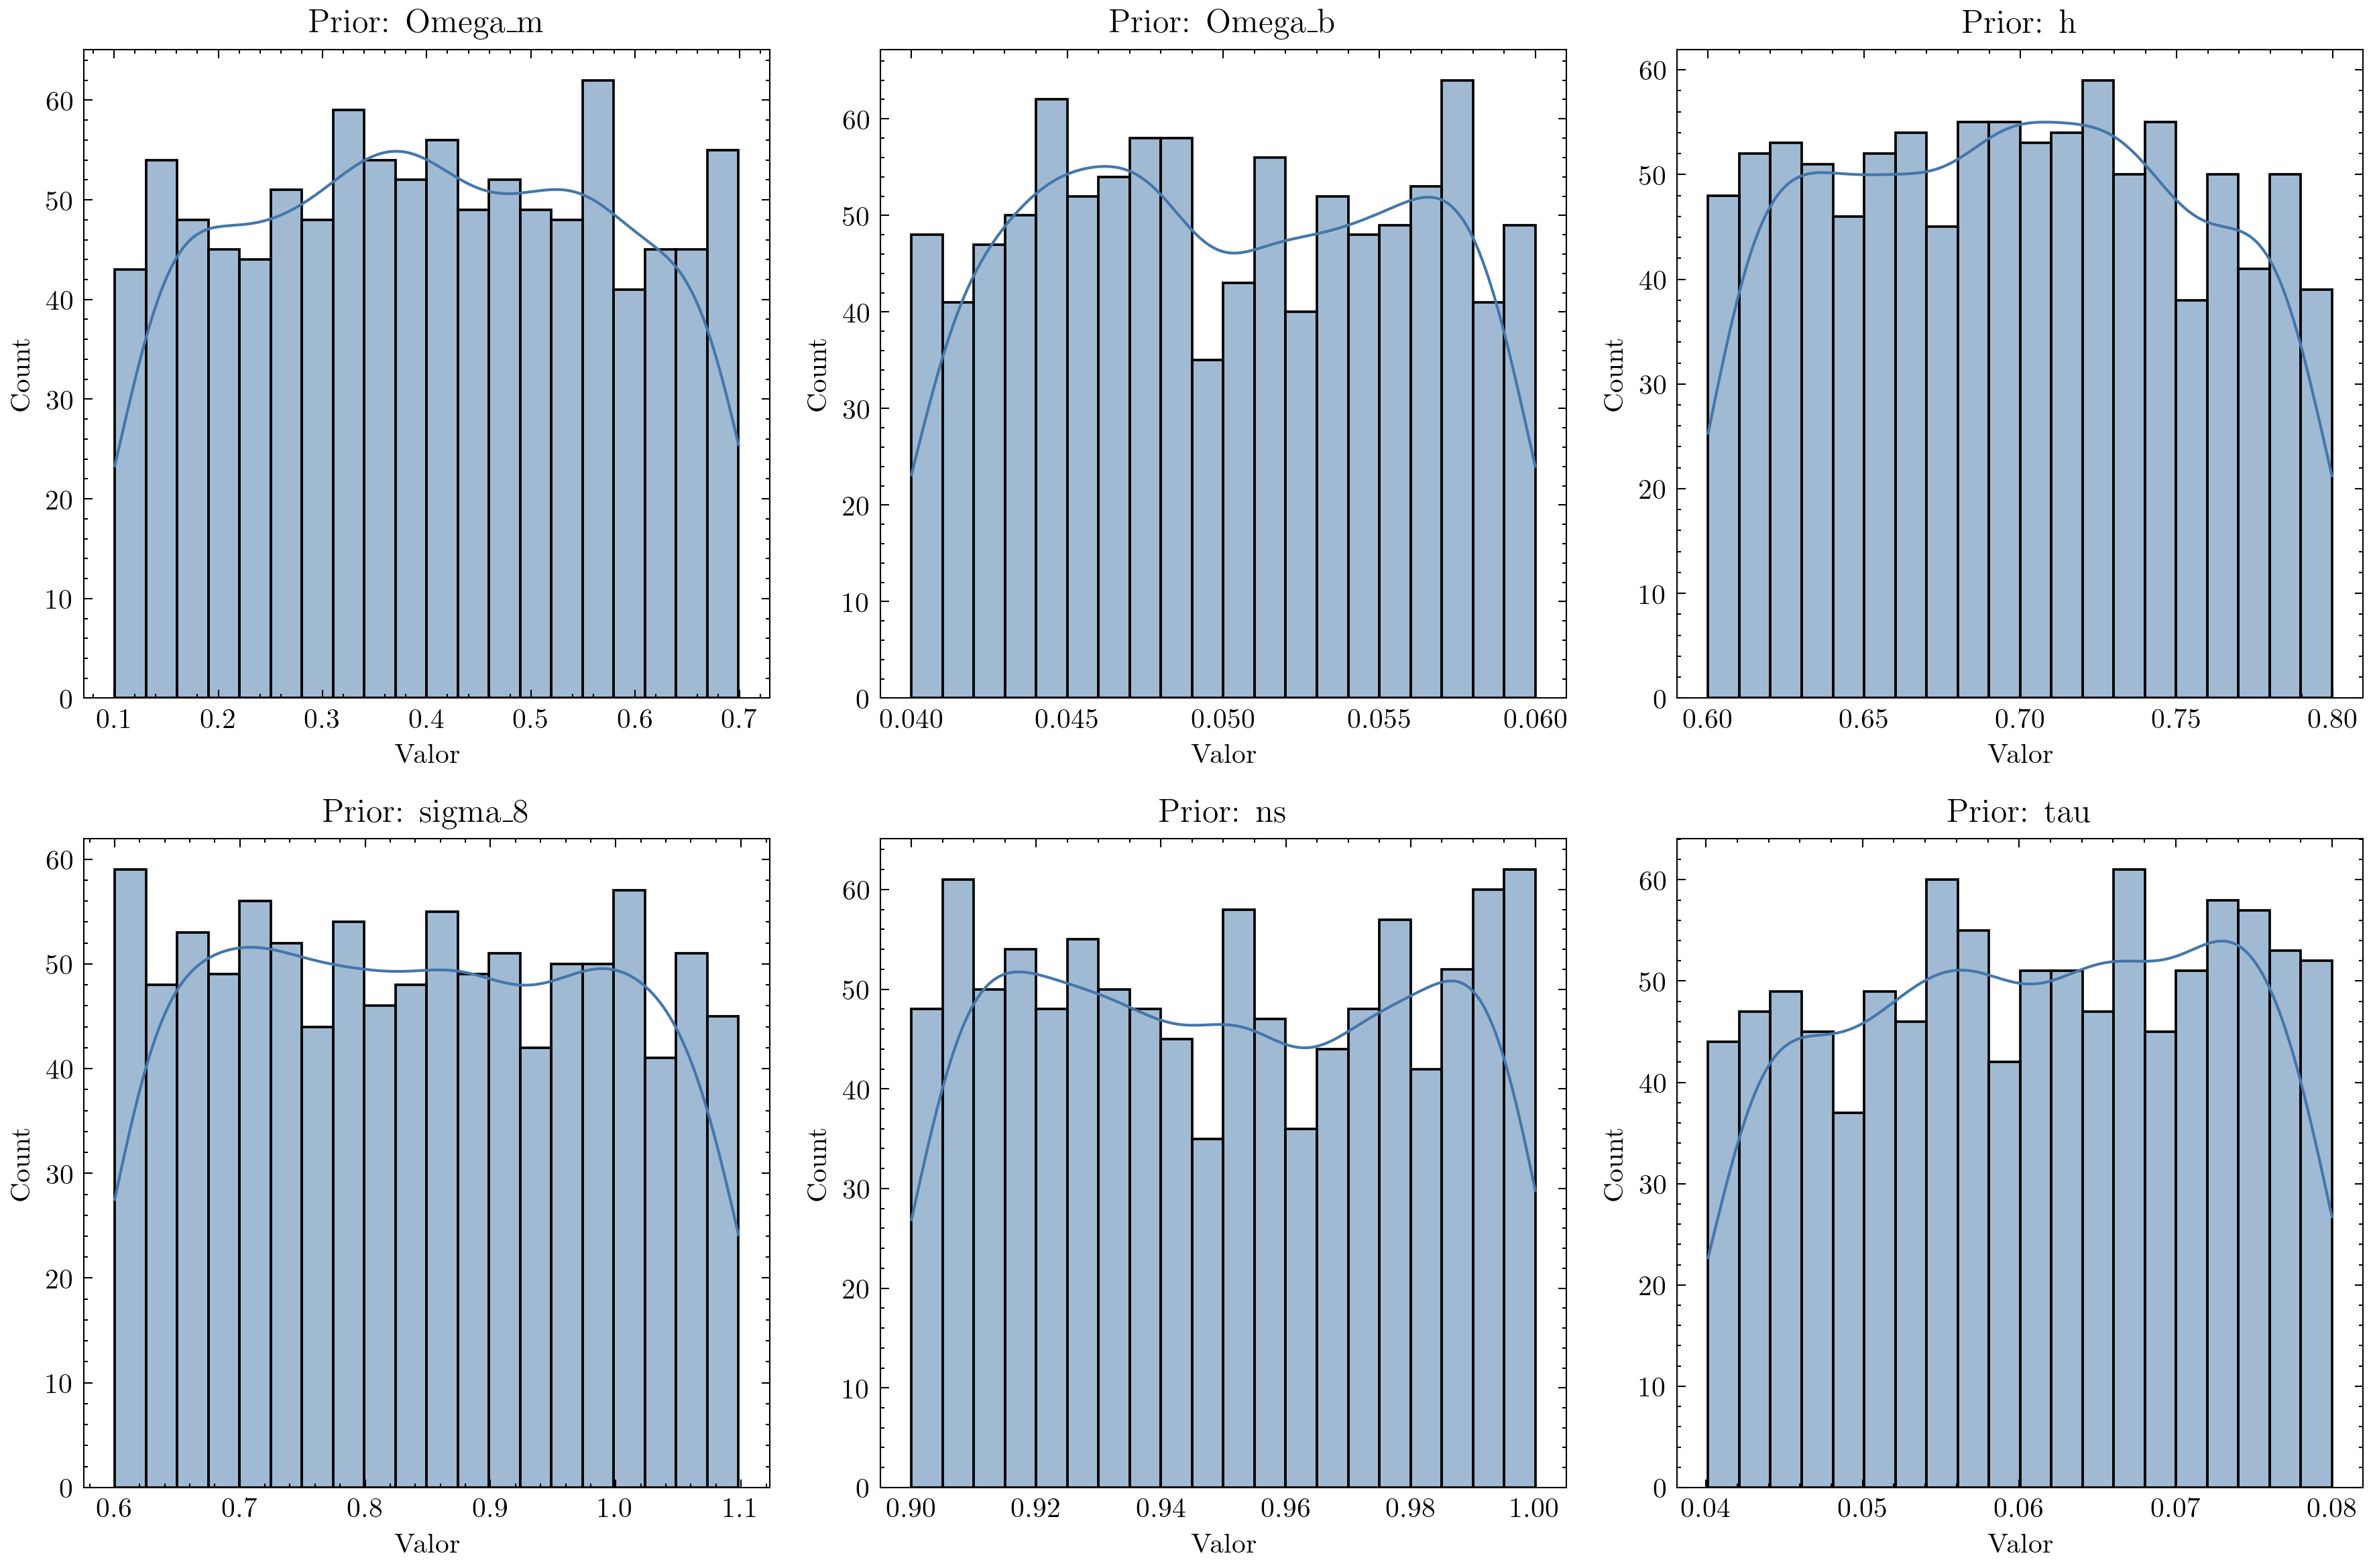

In [5]:
prior_samples = prior.sample((1000,))
param_names = list(PARAM_RANGES.keys())

plt.figure(figsize=(12, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 3, i+1)
    sns.histplot(prior_samples[:, i].numpy(), bins=20, kde=True)
    plt.title(f"Prior: {name}")
    plt.xlabel("Valor")
plt.tight_layout()
plt.show()

In [6]:
from src.inference.simulator import create_simulator

simulator = create_simulator()
test_theta = prior.sample((5,))
simulated_data = simulator(test_theta)

print("\n=== Prueba del Simulador ===")
print(f"Input theta shape: {test_theta.shape}")
print(f"Output spectra shape: {simulated_data.shape}")

Simulación 1/5 - Parámetros: [0.1460163  0.04594237 0.71086323 1.0191747  0.9715249  0.0698135 ]
Simulación 2/5 - Parámetros: [0.6404201  0.05258876 0.7123034  0.75826156 0.9635529  0.07664807]
Simulación 3/5 - Parámetros: [0.25786906 0.05922019 0.7739921  0.77897334 0.9061918  0.07081244]
Simulación 4/5 - Parámetros: [0.5818172  0.04127876 0.66139024 0.68602866 0.9592866  0.04794914]
Simulación 5/5 - Parámetros: [0.46908256 0.04037772 0.6427325  0.98292685 0.97052675 0.07434474]

=== Prueba del Simulador ===
Input theta shape: torch.Size([5, 6])
Output spectra shape: torch.Size([5, 2401])


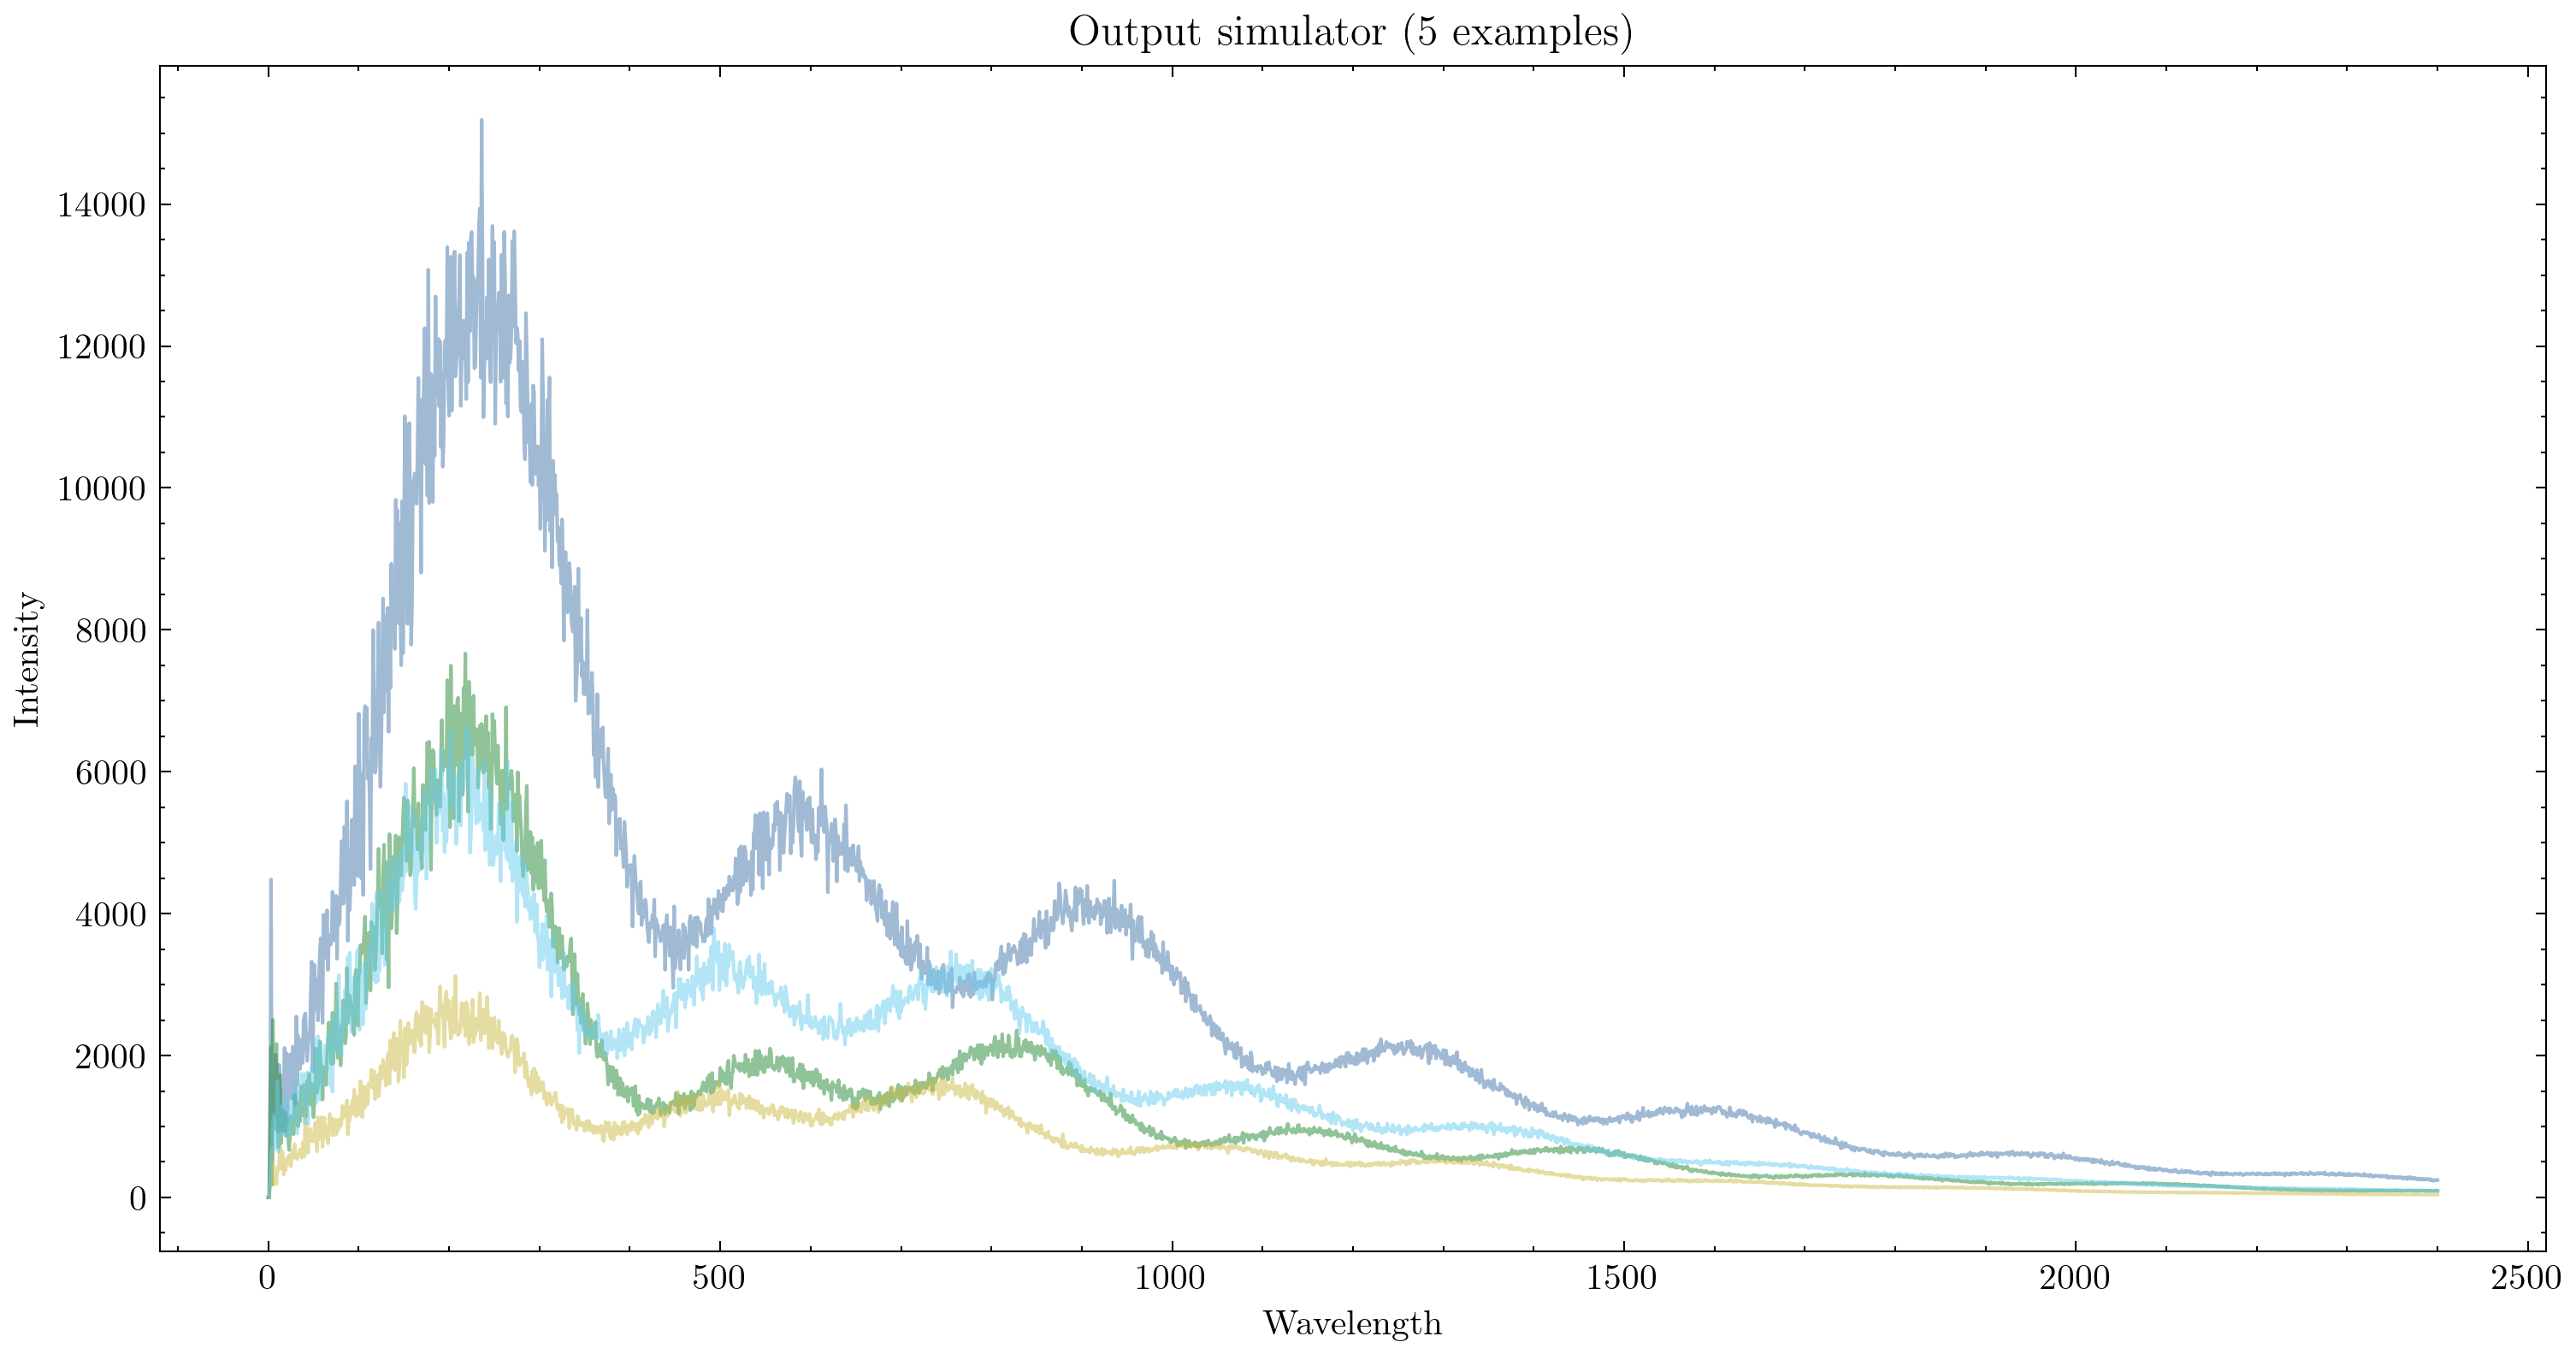

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(simulated_data.T, alpha=0.5)
plt.title("Output simulator (5 examples)")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.show()

In [8]:
from src.inference.utils import load_model
from src.inference.config import SBI_CONFIG
import time

start_time = time.time()
density_estimator = load_model(SBI_CONFIG["model_save_path"])
print(f"Modelo cargado en {time.time() - start_time:.2f} segundos")

Modelo cargado en 0.05 segundos


c:\Users\Julian\Documents\cmb-sbi-inference\src\inference\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


In [9]:
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import SNPE_C

embedding_net = CNNEmbedding(
    input_shape=(2401,),             
    in_channels=1,                   
    out_channels_per_layer=[16, 32, 64],  
    num_conv_layers=3,              
    num_linear_layers=2,           
    output_dim=8,                  
    kernel_size=5,                 
    pool_kernel_size=4             
)

neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

inference = SNPE_C(
    prior=prior,
    density_estimator=neural_posterior,
    device=SBI_CONFIG["device"]
)

posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [14]:
true_parameter = torch.tensor([[0.315, 0.049, 0.674, 0.811, 0.965, 0.054]])
x_observed = simulator(true_parameter)
samples = posterior.set_default_x(x_observed).sample((25000,))

Simulación 1/1 - Parámetros: [0.315 0.049 0.674 0.811 0.965 0.054]


Drawing 25000 posterior samples: 26645it [00:00, 35375.49it/s]                           


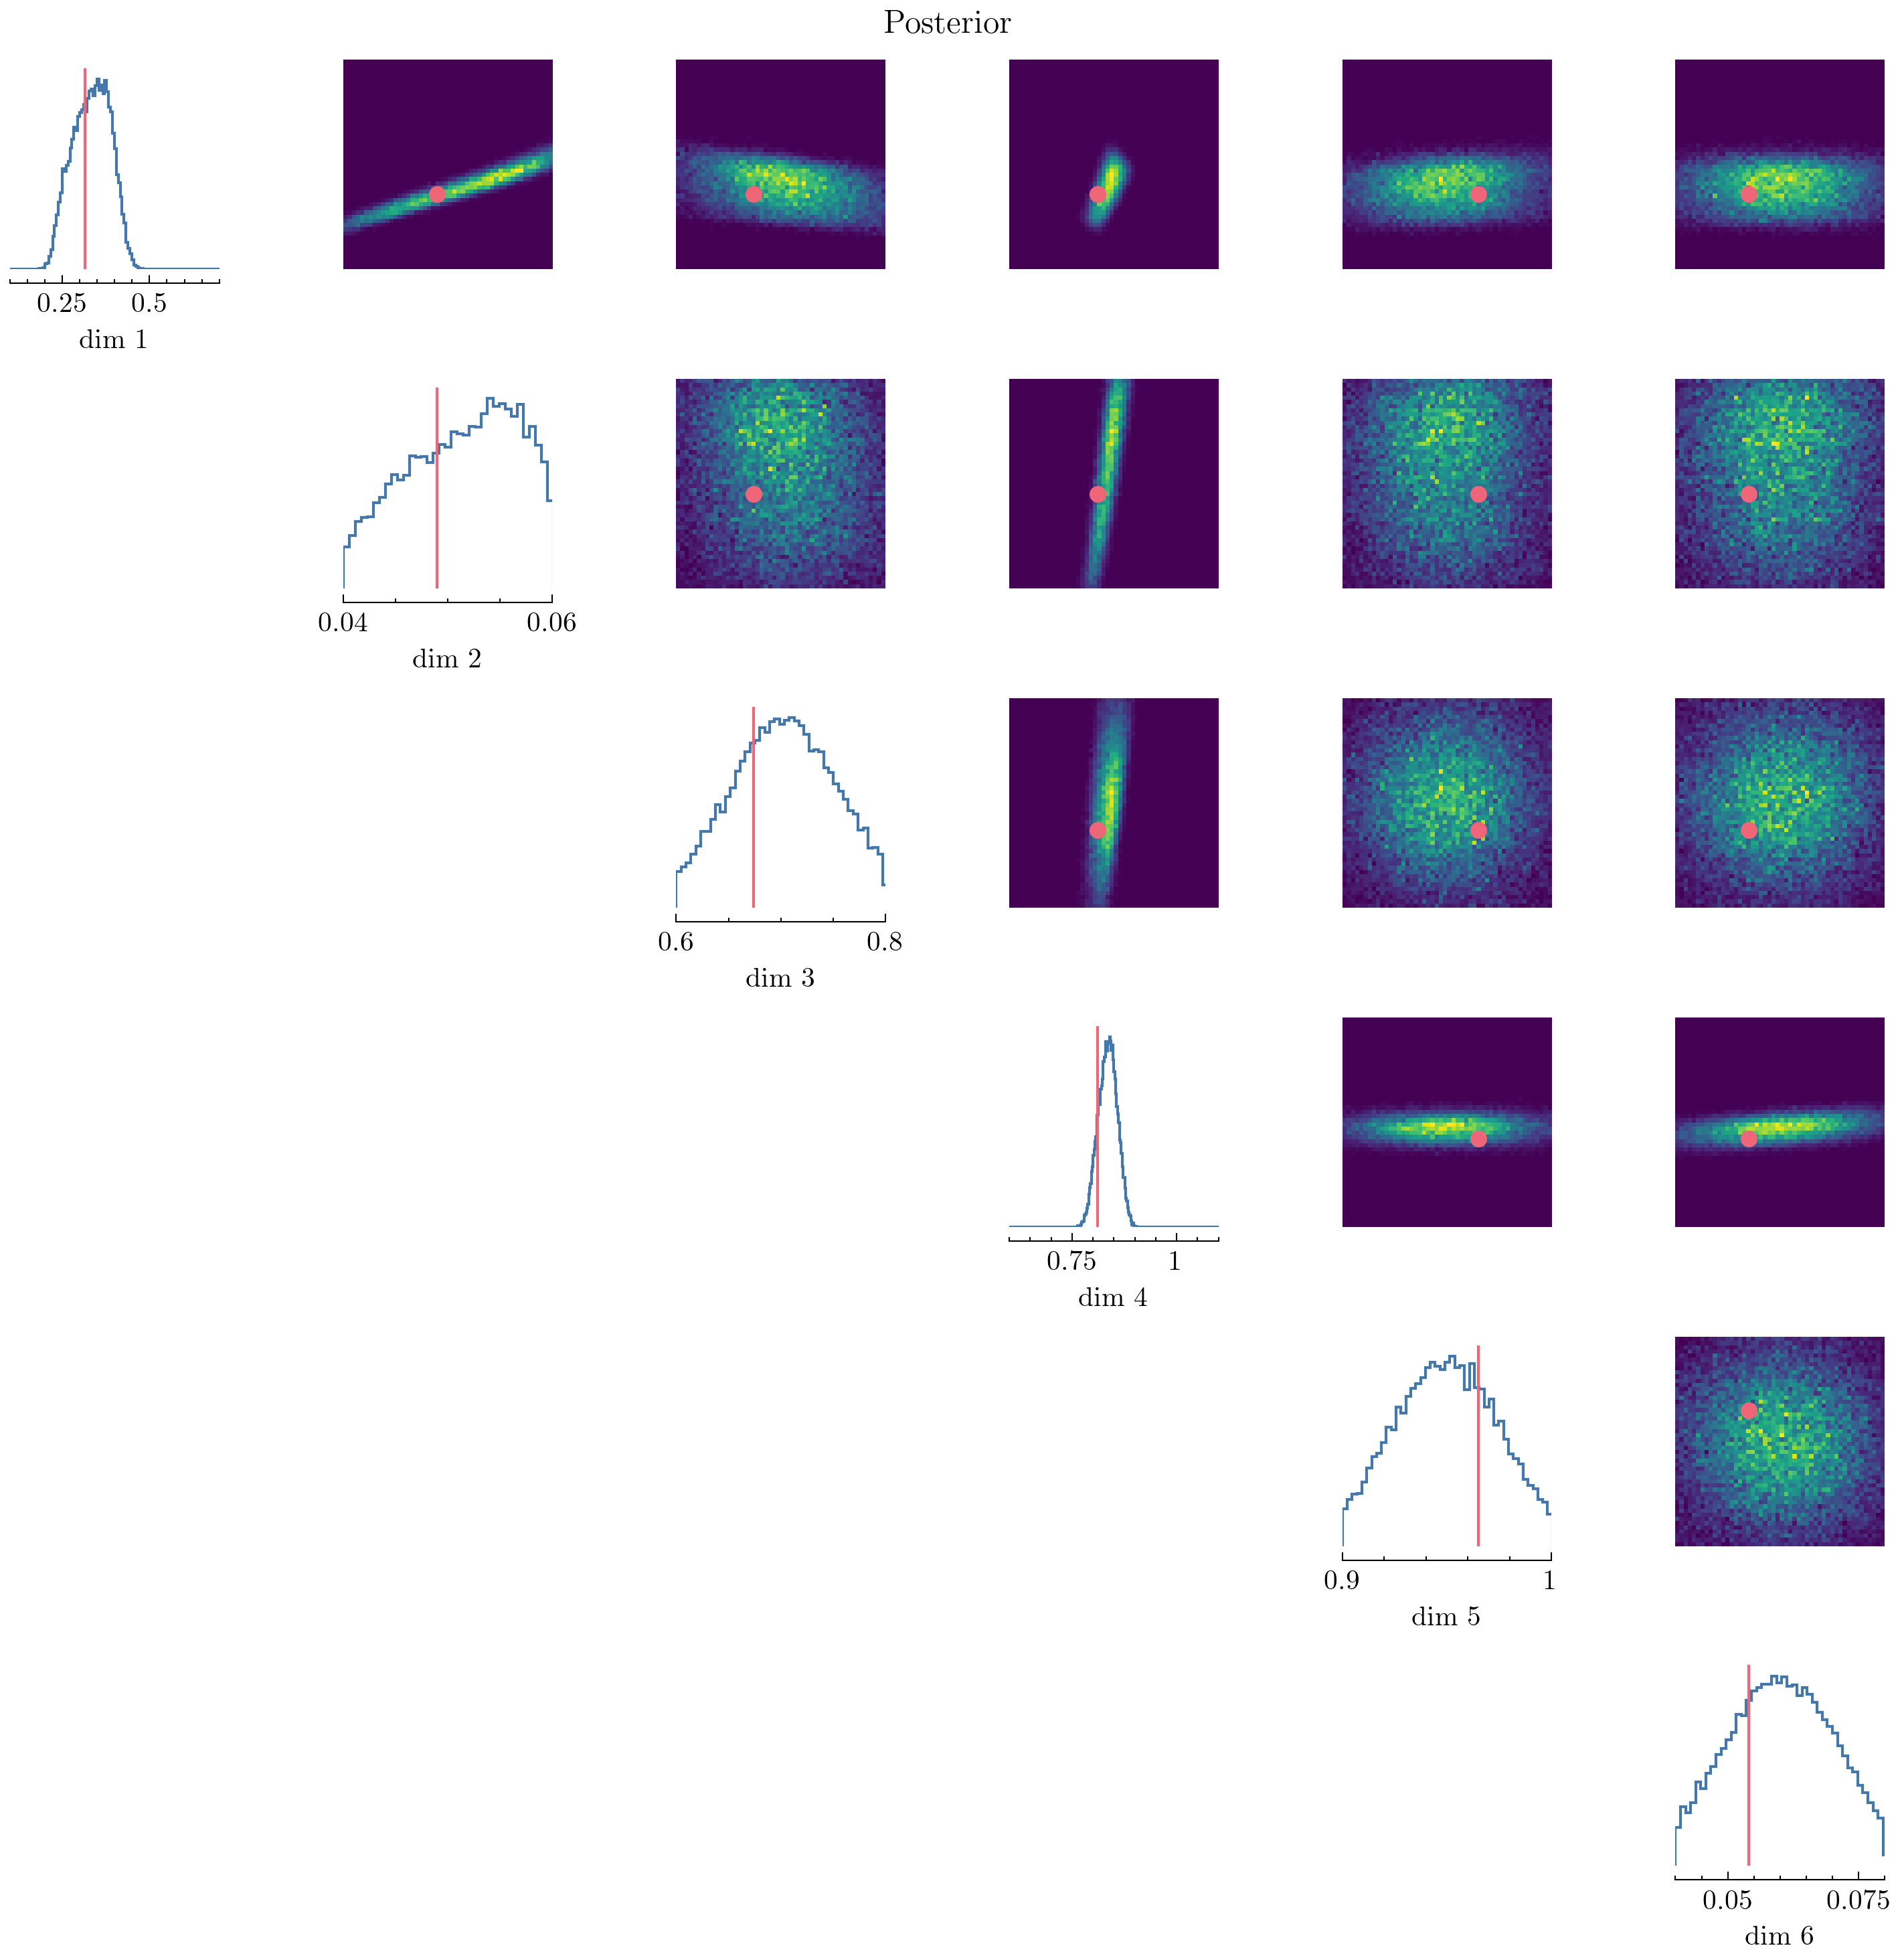

In [15]:
from sbi.analysis import pairplot

fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=[[0.1, 0.7], [0.04, 0.06], [0.6, 0.8], [0.6, 1.1], [0.9, 1.0], [0.04, 0.08]] # prior
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()